In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [2]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Plotting improts
import seaborn as sns

In [4]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [100]:
DATA_DIR = pathlib.Path("data/")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [101]:
!head -n 2 data/FordA/FordA_TRAIN.txt

  -1.0000000e+00  -7.9717168e-01  -6.6439208e-01  -3.7301463e-01   4.0815121e-02   5.2693599e-01   9.8428794e-01   1.3531202e+00   1.5781078e+00   1.6592509e+00   1.6408093e+00   1.5522896e+00   1.4379516e+00   1.2793537e+00   1.0691193e+00   7.4454700e-01   2.7760541e-01  -3.0072351e-01  -9.3732792e-01  -1.5200828e+00  -1.9516165e+00  -2.1360326e+00  -2.0401363e+00  -1.7229406e+00  -1.2619003e+00  -8.0454833e-01  -4.6153436e-01  -2.7822475e-01  -2.5130000e-01  -3.0183001e-01  -3.1326381e-01  -2.0445830e-01   6.7002208e-02   4.7161115e-01   9.3265143e-01   1.3531202e+00   1.6444976e+00   1.7588356e+00   1.6961341e+00   1.4822114e+00   1.1797690e+00   8.2569008e-01   4.4948122e-01   7.2534692e-02  -2.9703519e-01  -6.4595047e-01  -9.7421115e-01  -1.2508353e+00  -1.4094332e+00  -1.4278748e+00  -1.3024718e+00  -1.0627309e+00  -7.4922349e-01  -4.1727450e-01  -1.0745543e-01   1.6879990e-01   3.9784471e-01   5.7488417e-01   6.8553384e-01   7.1872874e-01   6.7815720e-01   5.4906592e-01   3.325

In [102]:
train = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.txt"),
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.txt"),
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [103]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [104]:
train.notnull().sum(axis=1).unique()

array([501])

In [105]:
test.notnull().sum(axis=1).unique()

array([501])

Let's change column names to something meaningful:

In [106]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [107]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [108]:
train.filter(like="val_")

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


The dataset is almost balanced:

In [109]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [111]:
N_SAMPLES = 10
N_COLS = 5
N_ROWS = 20 // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

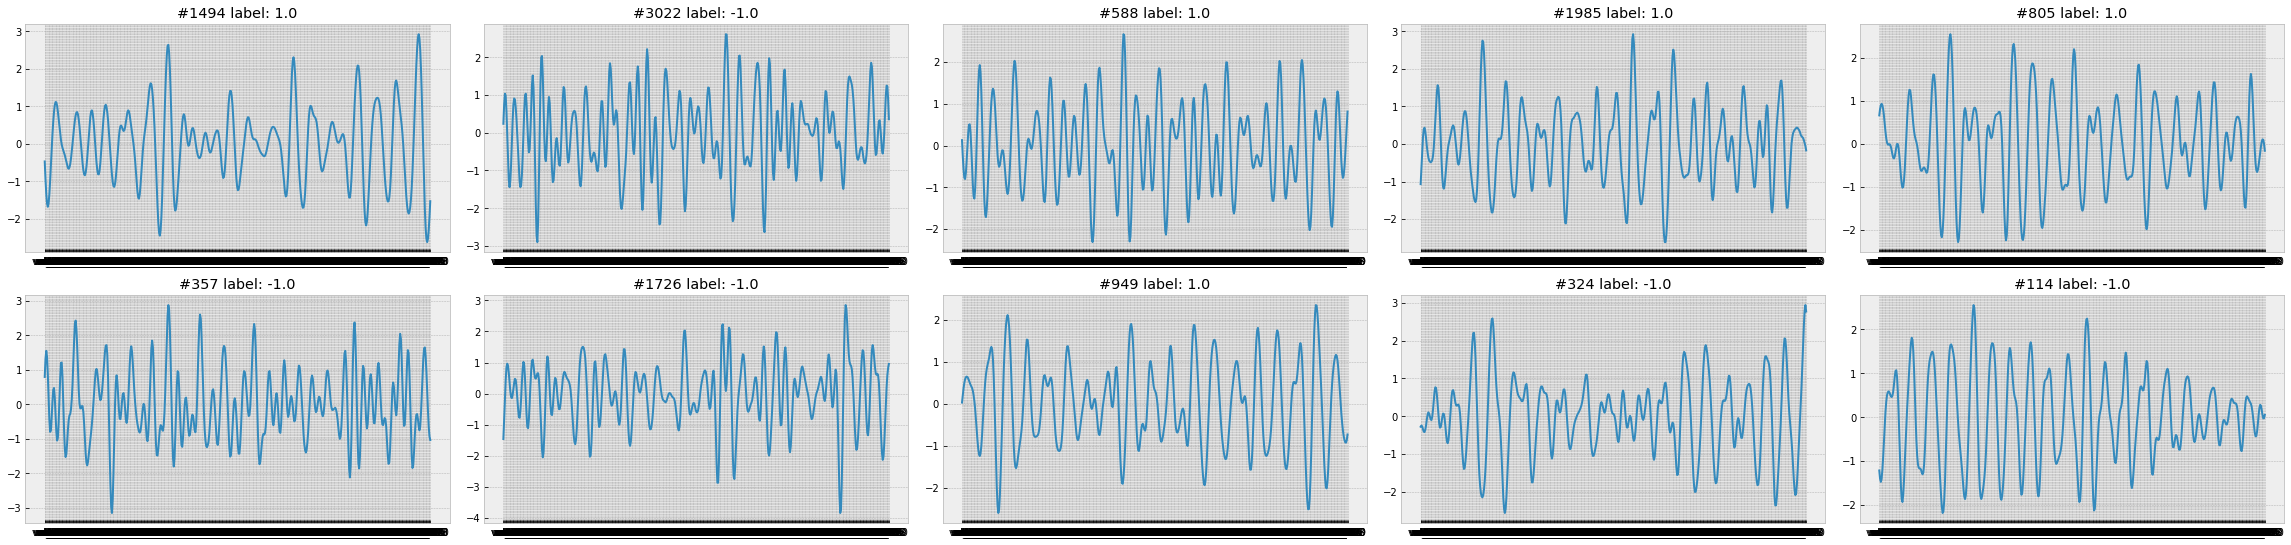

In [344]:
plt.figure(figsize=(8 * N_ROWS,  3* N_COLS))

for si, (sidx, sample) in enumerate(samples.iterrows()):
    # plot one sample here on a corresponding subplot    
    plt.subplot(N_ROWS, N_COLS, si+1)
    plt.plot(sample[1:]) 
    title_for_plt = '#' + str(sidx) + ' label: ' + str(sample[0]) 
    plt.title(title_for_plt)
    pass

plt.tight_layout();

In [129]:
train.loc[train["label"]==1]

,label,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
5,1.0,-0.540897,-1.014020,-1.298226,-1.320825,-1.082248,-0.637124,-0.090375,0.462991,0.923214,...,-0.731021,0.019686,0.790333,1.463596,1.942736,2.129041,1.986347,1.542409,0.909187,0.206006
6,1.0,-0.334060,-1.008014,-1.554353,-1.922185,-2.085926,-2.042102,-1.814500,-1.449649,-1.008381,...,-0.068962,0.183345,0.521307,0.879190,1.179716,1.362337,1.379528,1.211172,0.860810,0.359388
7,1.0,1.045890,0.611195,0.153108,-0.279675,-0.651621,-0.922651,-1.083900,-1.131134,-1.084075,...,0.797700,1.328339,1.663845,1.802068,1.765138,1.592741,1.329302,1.013114,0.674495,0.337014
8,1.0,0.825565,0.385282,-0.062416,-0.480982,-0.831189,-1.081840,-1.213596,-1.231525,-1.141304,...,0.082211,0.276728,0.494980,0.733670,0.966274,1.154837,1.265259,1.268105,1.136557,0.874347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,1.0,1.526902,1.749478,1.871714,1.849598,1.648510,1.284841,0.792988,0.201028,-0.396875,...,0.762240,0.561691,0.232087,-0.193461,-0.630024,-1.004991,-1.243052,-1.275207,-1.123714,-0.838664
3594,1.0,-0.525638,-0.569733,-0.547823,-0.493929,-0.432702,-0.374140,-0.319496,-0.269665,-0.221184,...,-0.897707,-0.985553,-1.008419,-0.979761,-0.902046,-0.767631,-0.589465,-0.385855,-0.171491,0.013573
3595,1.0,-0.984841,-1.116878,-1.172163,-1.169654,-1.134972,-1.076824,-0.982519,-0.838196,-0.632189,...,0.007520,0.621281,1.200920,1.721719,2.155832,2.480561,2.665433,2.684736,2.526477,2.190161
3597,1.0,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755


Text(0.5, 1.0, '#114 label: -1.0')

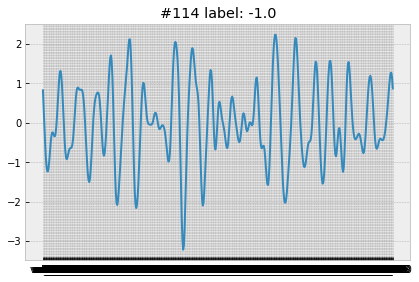

In [345]:
plt.figure(figsize=(40, 20))

plt.subplot(N_ROWS, N_COLS, si+1)
plt.plot(train.iloc[8][1:501]) 
title_for_plt = '#' + str(sidx) + ' label: ' + str(sample[0]) 
plt.title(title_for_plt)

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [140]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

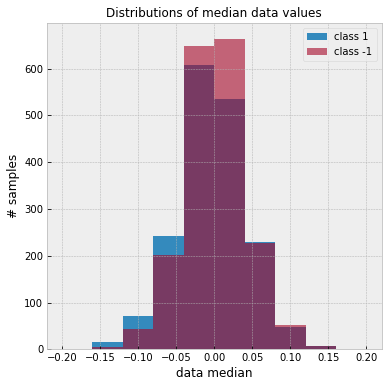

In [19]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

Answer: We are putting the (-) sign since the low predicted scores are associated with the label, and high predicted scores are not, so we put a negative number to remain the behaviour of looking on the area under the curve. 

In [20]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

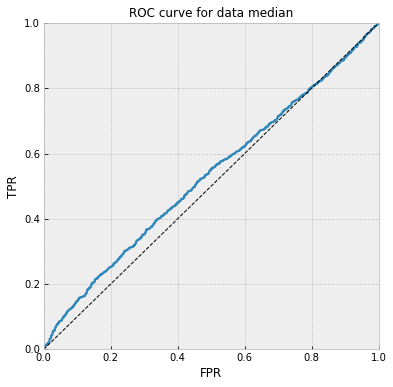

In [21]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

### Creating the fea

In [141]:
train["data_min"] = train.filter(like="val_").min(axis=1)
test["data_min"] = test.filter(like="val_").min(axis=1)

train["data_max"] = train.filter(like="val_").max(axis=1)
test["data_max"] = test.filter(like="val_").max(axis=1)

train["data_skew"] = train.filter(like="val_").skew(axis=1)
test["data_skew"] = test.filter(like="val_").skew(axis=1)

train["data_std"] = train.filter(like="val_").std(axis=1)
test["data_std"] = test.filter(like="val_").std(axis=1)

train["num_values_positive"] = (train.filter(like="val_") > 0).sum(axis=1) 
test["num_values_positive"] = (test.filter(like="val_") > 0).sum(axis=1) 

train["num_values_negative"] = (train.filter(like="val_") < 0).sum(axis=1) 
test["num_values_negative"] = (test.filter(like="val_") < 0).sum(axis=1) 

train["diff_positive_negative"] = train["num_values_positive"] - train["num_values_negative"]
test["diff_positive_negative"] = test["num_values_positive"] - test["num_values_negative"]

train["date_90th_percent"] = train.filter(like="val_").quantile(q=0.9, axis=1)
test["date_90th_percent"] = test.filter(like="val_").quantile(q=0.9, axis=1)

train["date_10th_percent"] = train.filter(like="val_").quantile(q=0.1, axis=1)
test["date_10th_percent"] = test.filter(like="val_").quantile(q=0.1, axis=1)

train["date_1st_percent"] = train.filter(like="val_").quantile(q=0.1, axis=1)
test["date_1st_percent"] = test.filter(like="val_").quantile(q=0.1, axis=1)

train["date_99th_percent"] = train.filter(like="val_").quantile(q=0.99, axis=1)
test["date_99th_percent"] = test.filter(like="val_").quantile(q=0.99, axis=1)

### Features with flat ROC 

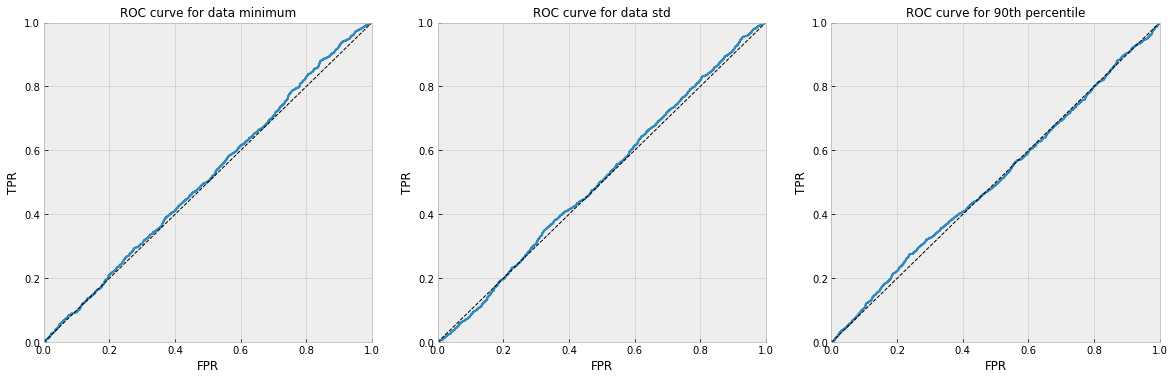

In [150]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
fpr, tpr, thr = roc_curve(train["label"], -train["data_min"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data minimum", fontsize=12);

plt.subplot(3, 3, 2)
fpr, tpr, thr = roc_curve(train["label"], train["data_std"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data std", fontsize=12);

plt.subplot(3, 3, 3)
fpr, tpr, thr = roc_curve(train["label"], -train["date_90th_percent"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for 90th percentile", fontsize=12);

### Features with potential ROC:

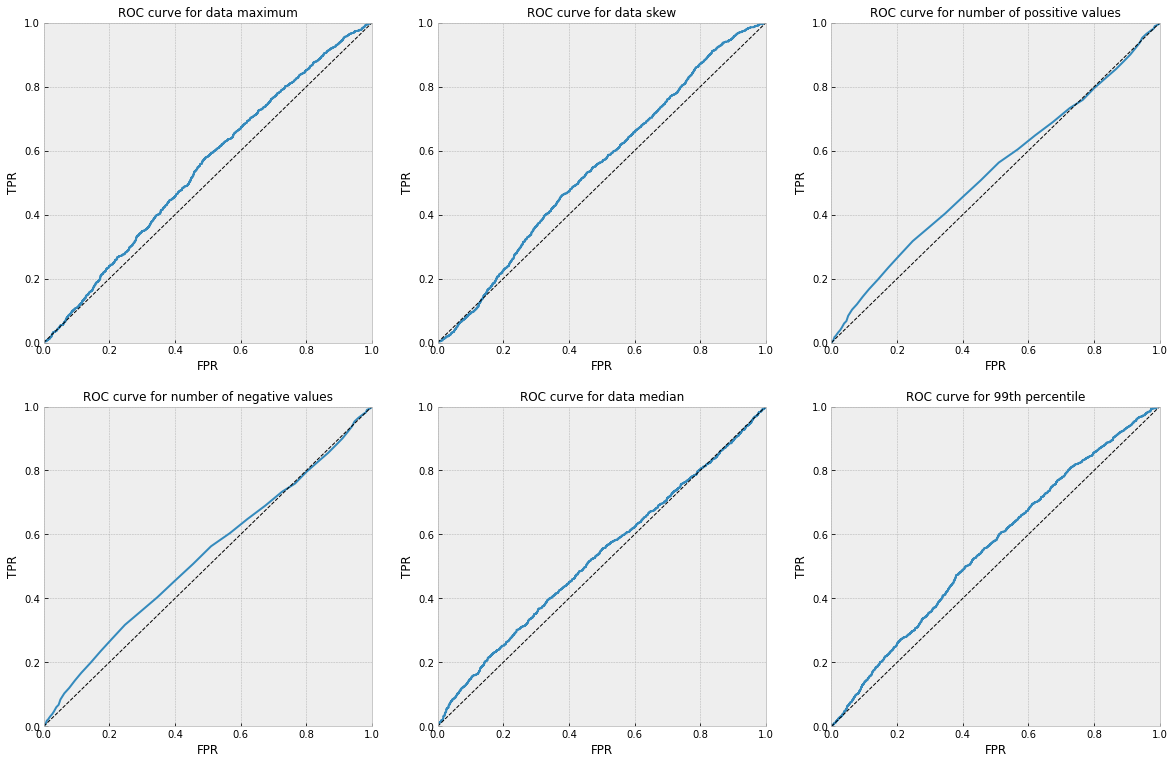

In [158]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
fpr, tpr, thr = roc_curve(train["label"], train["data_max"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data maximum", fontsize=12);

plt.subplot(3, 3, 2)

fpr, tpr, thr = roc_curve(train["label"], train["data_skew"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data skew", fontsize=12);

plt.subplot(3, 3, 3)

fpr, tpr, thr = roc_curve(train["label"], -train["num_values_positive"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for number of possitive values", fontsize=12);


plt.subplot(3, 3, 4)

fpr, tpr, thr = roc_curve(train["label"], train["num_values_negative"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for number of negative values", fontsize=12);

plt.subplot(3, 3, 5)

fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

plt.subplot(3, 3, 6)

fpr, tpr, thr = roc_curve(train["label"], train["date_99th_percent"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for 99th percentile", fontsize=12);

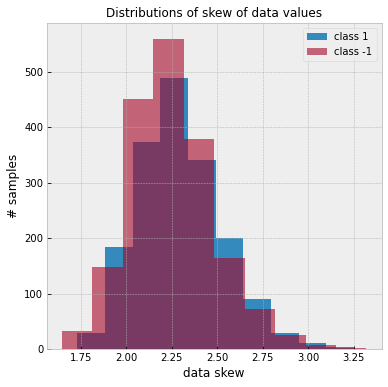

In [162]:
train.loc[train["label"]==1, "date_99th_percent"].plot(kind="hist",  label="class 1")
train.loc[train["label"]==-1, "date_99th_percent"].plot(kind="hist",  alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("99 percentile")
plt.ylabel("# samples")
plt.title("Distributions of 99th percentile", fontsize=12);

In [ ]:
# plot other statistics here - mean, std, skew, max, min, some quantiles
# consider calculating ROC AUC for each feature to perform a preliminary filtering of irrelevant features
# beware of NaNs - some statistics may be broken for some rows

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [40]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3597,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3598,0,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3599,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [41]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [42]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


**Step 3:** calculate counts.

In [43]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [44]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

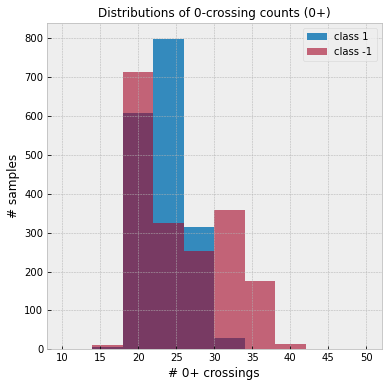

In [45]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

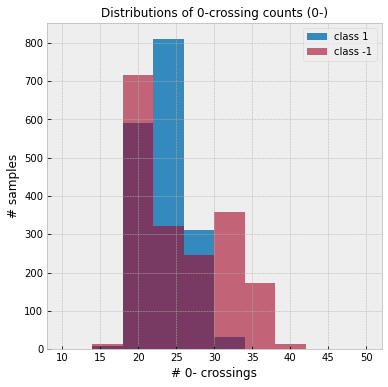

In [46]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [47]:
train.filter(like="zero").corr()

,zero+,zero-
zero+,1.000000,0.988801
zero-,0.988801,1.000000


In [48]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

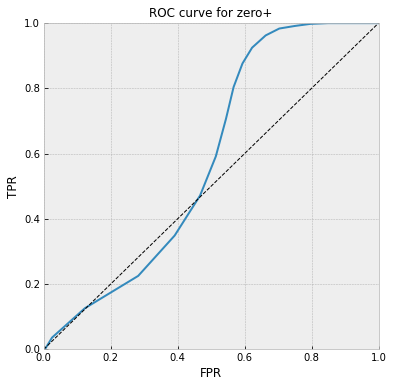

In [49]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

## Exploration

In [ ]:
# plot other features here - you may find various spectral features helpful here
# perform an analysis similar to one we did with number of 0-crossings
# beware of NaNs - some statistics may be broken for some rows

### Adding a feature that checks the number of values that are going up or down 

In [166]:
train["num_going_up"] = (train.filter(like="val_").diff(axis=1) > 0 ).sum(axis=1)
train["num_going_down"] = (train.filter(like="val_").diff(axis=1) < 0 ).sum(axis=1)

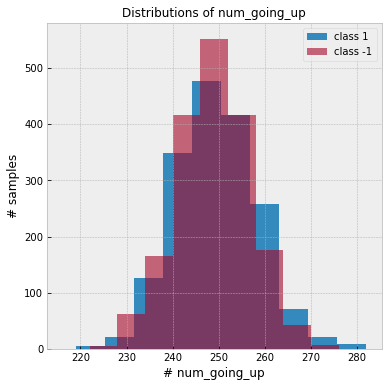

In [171]:
train.loc[train["label"]==1, "num_going_down"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "num_going_down"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of num_going_up", fontsize=12);

### Insight:
- Not that good measure. But the diff should make influence - maybe we'll try the std of the diff between following points:  

In [174]:
train["std_of_diff_between_cells"] = train.filter(like="val_").diff(axis=1).std(axis=1)

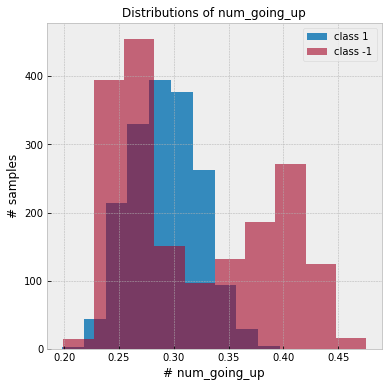

In [175]:
train.loc[train["label"]==1, "std_of_diff_between_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of following cells", fontsize=12);

Actually, looks like a good direction - let's check the ROC curve: 

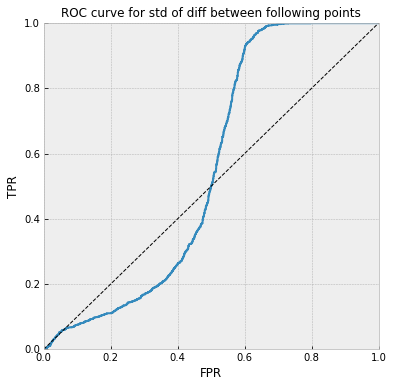

In [179]:
fpr, tpr, thr = roc_curve(train["label"], -train["std_of_diff_between_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between following points", fontsize=12);

### Insights: 
- STD of the diff between cells looks like a good separator. 
- Maybe we should find a better diff - let's try to find the diff between 2 minimaz or maximaz:

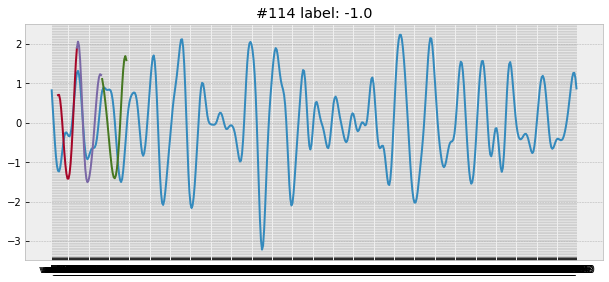

In [208]:
plt.figure(figsize=(60, 20))

plt.subplot(N_ROWS, N_COLS, si+1)
plt.plot(train.iloc[8][1:501]) 
title_for_plt = '#' + str(sidx) + ' label: ' + str(sample[0]) 
plt.title(title_for_plt)

plt.plot(train.iloc[9][7:26]) 

plt.plot(train.iloc[9][25:25+24]) 
plt.plot(train.iloc[9][49:49+24]) 

In [ ]:
train["std_of_diff_between_24_cells"] = train.filter(like="val_").diff(periods = -24, axis=1).std(axis = 1)

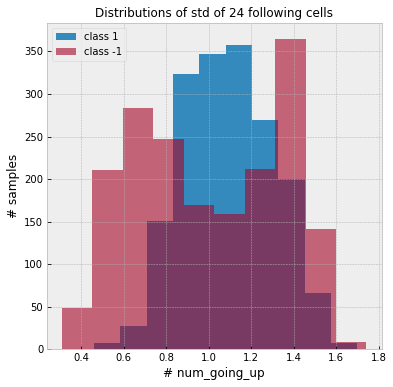

In [214]:
train.loc[train["label"]==1, "std_of_diff_between_24_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_24_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 24 following cells", fontsize=12);

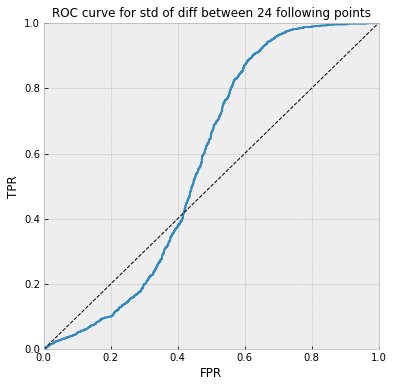

In [215]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_24_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 24 following points", fontsize=12);

### Insight: 
- Relatively good split - let's try to catch not a full cycle - but the gap between maximum and minimum: 

In [211]:
train["std_of_diff_between_10_cells"] = train.filter(like="val_").diff(periods = -10, axis=1).std(axis = 1)

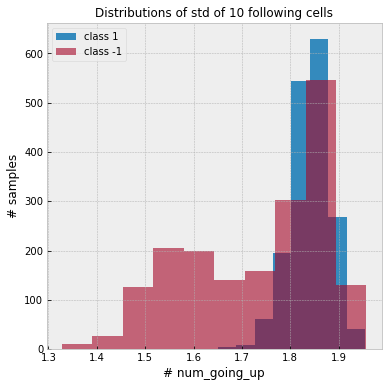

In [212]:
train.loc[train["label"]==1, "std_of_diff_between_10_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_10_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 10 following cells", fontsize=12);

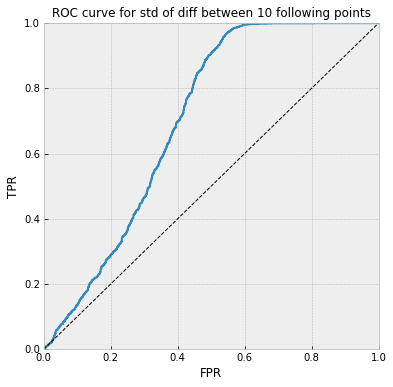

In [213]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_10_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 10 following points", fontsize=12);

### Much better!!! Let's try more options: 

In [216]:
train["std_of_diff_between_12_cells"] = train.filter(like="val_").diff(periods = -12, axis=1).std(axis = 1)

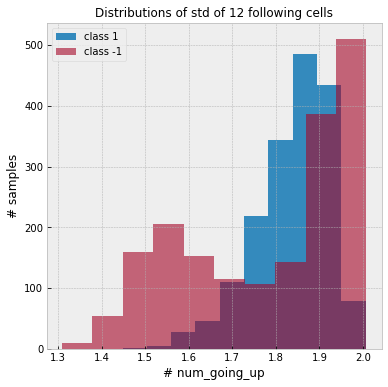

In [217]:
train.loc[train["label"]==1, "std_of_diff_between_12_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_12_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 12 following cells", fontsize=12);

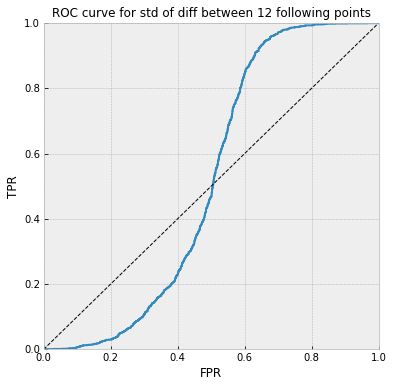

In [218]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_12_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 12 following points", fontsize=12);

### insight: 
- 10 cells were much better - we'll remove 12 cells - and try to look on a bit lower number. 

In [219]:
train.drop("std_of_diff_between_12_cells", axis=1, inplace=True)

Maybe 8? 

In [220]:
train["std_of_diff_between_8_cells"] = train.filter(like="val_").diff(periods = -8, axis=1).std(axis = 1)

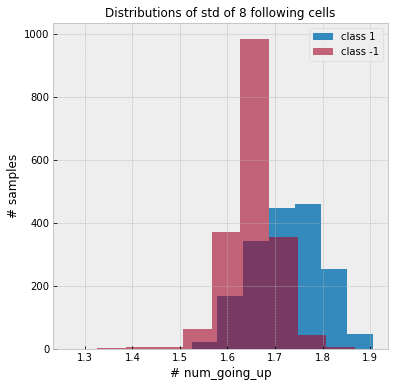

In [221]:
train.loc[train["label"]==1, "std_of_diff_between_8_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_8_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 8 following cells", fontsize=12);

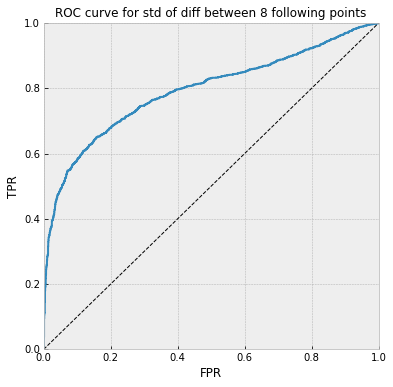

In [222]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_8_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 8 following points", fontsize=12);

# OMG! Let's keep going! 

In [339]:
train["std_of_diff_between_7_cells"] = train.filter(like="val_").diff(periods = -7, axis=1).std(axis = 1)

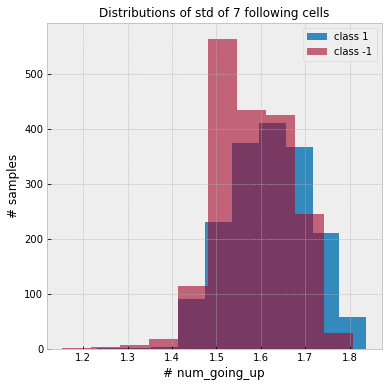

In [340]:
train.loc[train["label"]==1, "std_of_diff_between_7_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_7_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 7 following cells", fontsize=12);

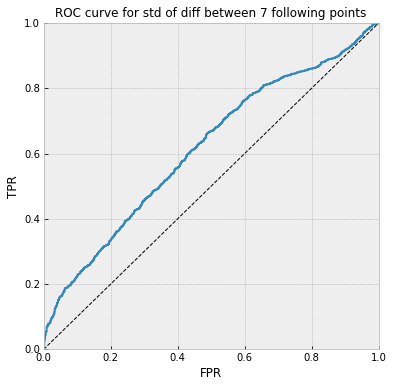

In [341]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_7_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 7 following points", fontsize=12);

### insights: 7 is less good - we'll remove it, and try 9: 

In [342]:
train.drop("std_of_diff_between_7_cells", axis=1, inplace=True)

In [237]:
train["std_of_diff_between_9_cells"] = train.filter(like="val_").diff(periods = -9, axis=1).std(axis = 1)

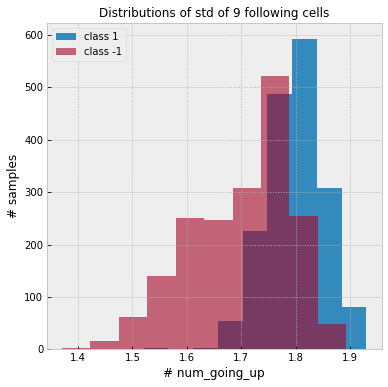

In [238]:
train.loc[train["label"]==1, "std_of_diff_between_9_cells"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "std_of_diff_between_9_cells"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# num_going_up")
plt.ylabel("# samples")
plt.title("Distributions of std of 9 following cells", fontsize=12);

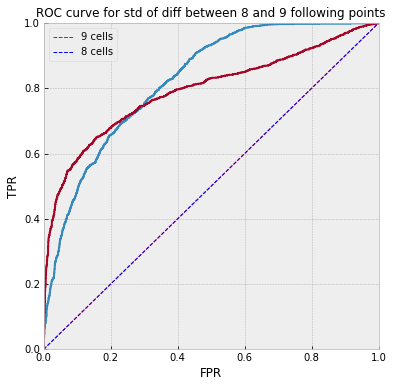

In [253]:
fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_9_cells"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", linewidth=1, color = 'red', label="9 cells")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for std of diff between 8 and 9 following points", fontsize=12);

#plt.title("ROC curve for std of diff between 9 following points", fontsize=12);




fpr, tpr, thr = roc_curve(train["label"], train["std_of_diff_between_8_cells"])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", linewidth=1, color = 'blue', label="8 cells")

plt.legend(loc=0)


## insight: 
- 8 looks the best metric! 

## Can we find a better feature? After an inspiration from a TSFresh
Let's try to find the uniqeness of the values in the time series as a rate between the unique values to the number of existing features

In [329]:
train["ratio_of_unique_values"] = train.filter(like="val_").nunique(axis=1)/500

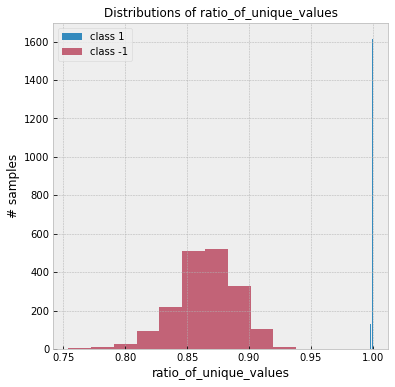

In [388]:
train.loc[train["label"]==1, "ratio_of_unique_values"].plot(kind="hist", label="class 1")
train.loc[train["label"]==-1, "ratio_of_unique_values"].plot(kind="hist", alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("ratio_of_unique_values")
plt.ylabel("# samples")
plt.title("Distributions of ratio_of_unique_values", fontsize=12);

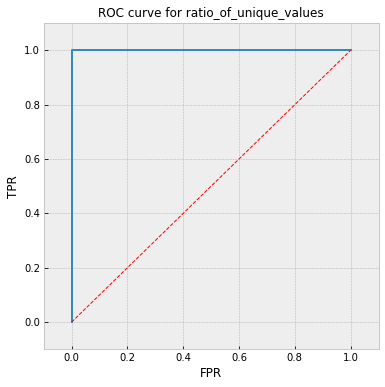

In [335]:
fpr, tpr, thr = roc_curve(train["label"], train["ratio_of_unique_values"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", linewidth=1, color = 'red', label="9 cells")

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for ratio_of_unique_values", fontsize=12);

# This feature gives us perfect results. 

# Now let's try to use the tsfresh
### First we need to prepare the data: 

In [295]:
train_test = train.filter(like="val_").copy()
train_test['index'] = train_test.index

train_test = train_test.melt(id_vars=['index'])
train_test['time'] = train_test.variable.str.replace('val_', '')
train_test = train_test.astype({'time': 'int64'})

train_test.drop("variable", axis=1, inplace=True)

This is the table with the needed format: 

In [347]:
train_test

,index,value,time
0,0,-0.797172,1
1,1,0.804855,1
2,2,0.727985,1
3,3,-0.234439,1
4,4,-0.171328,1
...,...,...,...
1800495,3596,-2.603753,500
1800496,3597,-0.393755,500
1800497,3598,-0.270722,500
1800498,3599,-0.280709,500


In [361]:
y = train.filter(like="label").copy().squeeze()
# type(y)

In [307]:
from tsfresh import extract_features, extract_relevant_features
#extracted_features = extract_features(train_test, column_id="index", column_sort="time")

features_filtered_direct = extract_relevant_features(train_test, y,
                                                     column_id='index', column_sort='time')

Feature Extraction: 100%|███████████████████████| 25/25 [13:57<00:00, 33.48s/it]


In [308]:
features_filtered_direct

,value__ratio_value_number_to_time_series_length,value__percentage_of_reoccurring_values_to_all_values,value__has_duplicate,value__ar_coefficient__coeff_2__k_10,value__ar_coefficient__coeff_1__k_10,value__has_duplicate_max,value__ar_coefficient__coeff_3__k_10,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__ar_coefficient__coeff_10__k_10,value__autocorrelation__lag_9,...,value__count_below__t_0,value__ar_coefficient__coeff_7__k_10,value__quantile__q_0.8,value__quantile__q_0.7,"value__fft_coefficient__attr_""abs""__coeff_81",value__kurtosis,value__ratio_beyond_r_sigma__r_2,"value__fft_coefficient__attr_""abs""__coeff_87",value__median,value__benford_correlation
0,0.858,0.142191,1.0,-3.513505,3.149348,0.0,1.357700,0.264,-0.267906,-0.330288,...,0.510,-0.020952,0.926012,0.563819,1.289054,-0.860876,0.014,0.811061,-0.030960,0.893101
1,1.000,0.000000,0.0,-4.380467,3.416923,0.0,2.466510,0.000,-0.339405,-0.467373,...,0.488,-0.014005,0.852752,0.618400,1.362088,-0.434198,0.050,1.174955,0.035526,0.902698
2,0.844,0.156398,1.0,-3.316191,3.122092,0.0,0.927059,0.288,-0.201010,-0.153110,...,0.492,-0.563488,0.829930,0.543289,0.828583,-0.040417,0.060,0.876967,0.076201,0.941966
3,0.846,0.141844,1.0,-3.252090,3.002049,0.0,1.440654,0.274,-0.249314,-0.624026,...,0.496,-0.286882,0.816404,0.539339,0.981037,0.039097,0.052,0.617539,0.011714,0.924008
4,0.902,0.097561,1.0,-3.410983,3.025146,0.0,1.494753,0.186,-0.186915,-0.218543,...,0.472,-0.298512,0.750734,0.528227,1.100507,1.695826,0.050,1.275325,0.092380,0.973003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.860,0.139535,1.0,-3.220484,3.000537,1.0,1.189788,0.260,-0.308010,-0.547472,...,0.494,-0.505237,0.685050,0.421590,3.411954,1.715766,0.072,3.078200,0.010031,0.991626
3597,1.000,0.000000,0.0,-3.587453,3.235615,0.0,0.864664,0.000,-0.327391,-0.719452,...,0.470,-0.441619,0.757181,0.425821,0.465533,0.402973,0.052,0.259597,0.039984,0.971452
3598,0.864,0.134259,1.0,-3.415473,3.047947,0.0,1.427371,0.252,-0.184731,-0.325022,...,0.480,0.101349,0.895486,0.542630,0.706318,-0.129031,0.040,0.943293,0.052548,0.951902
3599,1.000,0.000000,0.0,-4.099710,3.342325,0.0,1.935131,0.000,-0.286851,-0.516376,...,0.506,0.063167,1.022153,0.667804,2.493179,-0.719546,0.030,2.227375,-0.015627,0.879490


In [309]:
features_filtered_direct.columns

Index(['value__ratio_value_number_to_time_series_length',
       'value__percentage_of_reoccurring_values_to_all_values',
       'value__has_duplicate', 'value__ar_coefficient__coeff_2__k_10',
       'value__ar_coefficient__coeff_1__k_10', 'value__has_duplicate_max',
       'value__ar_coefficient__coeff_3__k_10',
       'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'value__ar_coefficient__coeff_10__k_10',
       'value__autocorrelation__lag_9',
       ...
       'value__count_below__t_0', 'value__ar_coefficient__coeff_7__k_10',
       'value__quantile__q_0.8', 'value__quantile__q_0.7',
       'value__fft_coefficient__attr_"abs"__coeff_81', 'value__kurtosis',
       'value__ratio_beyond_r_sigma__r_2',
       'value__fft_coefficient__attr_"abs"__coeff_87', 'value__median',
       'value__benford_correlation'],
      dtype='object', length=233)

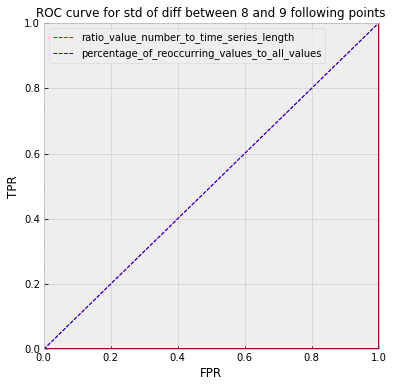

In [320]:
fpr, tpr, thr = roc_curve(train["label"], -features_filtered_direct["value__ratio_value_number_to_time_series_length"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", linewidth=1, color = 'red', label="ratio_value_number_to_time_series_length")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for ratio value number to time series length"])
", fontsize=12);



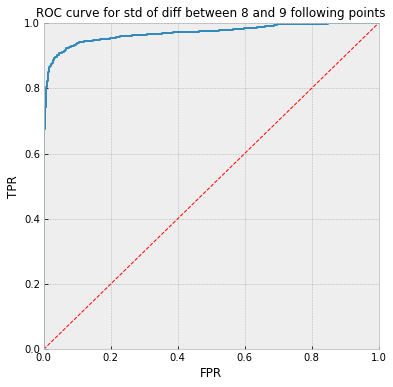

In [337]:
fpr, tpr, thr = roc_curve(train["label"], -features_filtered_direct["value__ar_coefficient__coeff_2__k_10"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", linewidth=1, color = 'red', label="value__ar_coefficient__coeff_2__k_10")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for ar coefficient coeff 2 k 10", fontsize=12);

## Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [ ]:
# do the train/validation split
# train a model
# check the performance on the test set

In [362]:
from sklearn.model_selection import train_test_split
X_feature_train, X_feature_validation, y_train, y_validation = train_test_split(features_filtered_direct, y, test_size=.2)

In [363]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(X_feature_train, y_train)
print(classification_report(y_validation, classifier_feature.predict(X_feature_validation)))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       364
         1.0       1.00      1.00      1.00       357

    accuracy                           1.00       721
   macro avg       1.00      1.00      1.00       721
weighted avg       1.00      1.00      1.00       721



### Prepare the Test data: 

In [364]:
test_final = test.filter(like="val_").copy()
test_final['index'] = test_final.index

test_final = test_final.melt(id_vars=['index'])
test_final['time'] = test_final.variable.str.replace('val_', '')
test_final = test_final.astype({'time': 'int64'})

test_final.drop("variable", axis=1, inplace=True)

In [365]:
y_test = test.filter(like="label").copy().squeeze()

In [366]:
from tsfresh import extract_features
extracted_features = extract_features(test_final, column_id="index", column_sort="time")

Feature Extraction: 100%|███████████████████████| 25/25 [03:31<00:00,  8.45s/it]


In [383]:
extracted_features_no_nulls = extracted_features[features_filtered_direct.columns].copy()

In [387]:
print(classification_report(y_test, classifier_feature.predict(extracted_features_no_nulls.fillna(0))))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       681
         1.0       1.00      1.00      1.00       639

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320

